<a href="https://colab.research.google.com/github/Yuan325/CSCI6364_MachineLearning/blob/main/Project3/MNIST_Random_Forest_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shared Code between Random Forest and KNN

In [1]:
import csv
import numpy as np
from google.colab.patches import cv2_imshow
from math import *
import random
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
from google.colab import files

files.upload() # upload data file

In [3]:
# evaluation functions

def confusionMatrix(y, yhat, n):
  mat = np.zeros((n, n))
  for y_val, yhat_val in zip(y, yhat):
    mat[y_val][yhat_val] += 1
  print(mat)
  return mat

def confusionValues(mat, index):
  tn = fp = fn = tp = 0
  tp = mat[index][index]
  for i in range(len(mat)): # truth value
    for j in range(len(mat)): #prediction value
      if i == index and j != index:
        fn += mat[i][j]
      elif i != index and j == index:
        fp += mat[i][j]
      elif i != index and j!= index:
        tn += mat[i][j]
  return tn, fp, fn, tp

def accuracy(tn, fp, fn, tp):
  return (tp + tn)/(tp+tn+fp+fn)

def sensitivity(tn, fp, fn, tp):
  return tp/(tp+fn)

def specificity(tn, fp, fn, tp):
  return tn/(tn+fp)

def pos_pred_val(tn, fp, fn, tp):
  return tp/(tp+fp)

def false_positive_rate(tn, fp, fn, tp):
  return fp/(tn+fp)

def f1score(tn, fp, fn, tp):
  return 2*tp/(2*tp + fp + fn)

def runEval(y, yhat, n, index):
  mat = confusionMatrix(y, yhat, n)
  tn, fp, fn, tp = confusionValues(mat, index)
  print("TN: ", tn, "\tFP: ", fp, "\nFN: ", fn, "\tTP: ", tp)
  print("Accuracy: ", accuracy(tn, fp, fn, tp))
  print("Sensitivity: ", sensitivity(tn, fp, fn, tp))
  print("Specificity: ", specificity(tn, fp, fn, tp))
  print("Positive Predictive Value: ", pos_pred_val(tn, fp, fn, tp))
  print("False Positive Rate: ", false_positive_rate(tn, fp, fn, tp))
  print("F1 Score: ", f1score(tn, fp, fn, tp))

In [4]:
def printScatterplot(x1, x2, name1="Data 1", name2 = "Data 2"):
  plt.style.use('seaborn-whitegrid')
  plt.plot(x1, x2, 'o')
  plt.xlabel(name1)
  plt.ylabel(name2)
  plt.show()

In [5]:
def printSample(train_x, train_y):
  ro = np.zeros((28, 28, 3))
  for n in range(10):
    for index in range(len(train_y)):
      if n == train_y[index]:
        for i in range(0, 27):
          for j in range(0, 27):
            ro[i,j,0] = train_x[index, j+i*28]
            ro[i,j,1] = train_x[index, j+i*28]
            ro[i,j,2] = train_x[index, j+i*28]
        cv2_imshow(ro)
        print()
        break

def readyData():
  reader = csv.reader(open('/content/MNIST.csv', 'r'))
  header = next(reader)
  data=[]

  for row in reader: 
    data.append(row)
  data = np.array(data)
  data = data.astype(np.int)
  np.random.shuffle(data)
  data_x = data[:, 1:]
  data_y = data[:, 0]

  printSample(data_x, data_y)
  return data_x, data_y

# Random Forest

In [7]:
data_x, data_y = readyData()
  
split = 10000
split2 = 33600

train_x = data_x[:split, :]
train_y = data_y[:split]
test_x = data_x[split2:, :]
test_y = data_y[split2:]

In [8]:
class RandomForest:
  def __init__(self, sample_n, tree_n, feature_n, min_leaf, max_depth, class_n, min_split):
    self.sampleN = sample_n
    self.treeN = tree_n
    self.featureN = feature_n
    self.min_leaf = min_leaf 
    self.max_depth = max_depth
    self.class_n = class_n
    self.min_split = min_split
    self.trees = []
  
  def fit(self, train_x, train_y):
    while len(self.trees) != self.treeN:
      tree = self.create_tree(train_x, train_y)
      if tree != None: 
        self.trees.append(tree) 

  def create_tree(self, train_x, train_y):
    sample_x, sample_y = self.getSample(train_x, train_y)
    new_t = DecisionTree(self.class_n, self.getFeatures(train_x), self.max_depth, self.max_depth, self.min_leaf, self.min_split, sample_x, sample_y)
    temp = new_t.runTree()
    return new_t if temp != False else None
  
  def predict(self, xs):
    final_pred = []
    for x in xs:
      pred = [t.predict(x) for t in self.trees]
      most_common = max(pred, key = pred.count)
      final_pred.append(most_common)
    return final_pred

  def getSample(self, train_x, train_y):
    idx = np.random.choice(train_x.shape[0], size=self.sampleN)
    return train_x[idx,:], train_y[idx]

  def getFeatures(self, train_x):
    return random.sample(range(0,len(train_x[0])), self.featureN)

In [9]:
class DecisionTree:
  def __init__(self, class_n, features, depth, max_depth, leaf, min_split, sample_x, sample_y):
    self.class_n = class_n
    self.features = features
    self.depth = depth
    self.max_depth = max_depth
    self.leaf = leaf
    self.min_split = min_split
    self.xs = sample_x
    self.ys = sample_y
    self.res = None

  def runTree(self):
    if self.depth <= 0 or len(self.xs) < self.leaf:
      return self.calculateResult() if self.depth != self.max_depth else False
    res = self.getFeature()
    return res

  def calculateResult(self):
    self.res = np.bincount(self.ys).argmax()
    print(self.res, " ", self.depth)
    return self.res

  def getFeature(self):
    self.gini_score = float('inf')
    for f in self.features:
      set_x =np.unique(self.xs[:, f])
      if len(set_x) > 1:
        split_value, cur_gini = self.getSplit(self.xs[:, f], set_x, self.ys)
        if cur_gini < self.gini_score:
          self.split = split_value
          self.col_id = f
          self.gini_score = cur_gini

    if split_value == -1:
      return self.calculateResult() if self.depth != self.max_depth else False
    self.features.remove(self.col_id)

    t = self.xs[:,self.col_id].argsort()
    new_x = self.xs[t]
    new_y = self.ys[t]
    s = np.count_nonzero(self.xs[:,self.col_id] < self.split)

    self.lt = DecisionTree(self.class_n, self.features, self.depth-1, self.max_depth, self.leaf, self.min_split, new_x[:s, :], new_y[:s])
    self.lt.runTree()
    self.rt = DecisionTree(self.class_n, self.features, self.depth-1, self.max_depth, self.leaf, self.min_split, new_x[s:, :], new_y[s:])
    self.rt.runTree()
    self.features.append(self.col_id)
    return

  def getSplit(self, xs, x_set, ys):
    best_s = -1
    best_gini = float('inf')
    for x in x_set:
      if np.count_nonzero(xs < x) >= self.min_split and np.count_nonzero(xs >= x) >= self.min_split:
        temp = self.giniIndex(x, xs, ys)
        if temp < best_gini:
          best_gini = temp
          best_s = x
    return best_s, best_gini

  def giniIndex(self, test_split, xs, ys): 
    p = [0] * self.class_n 
    for i in range(self.class_n):
      p[i] = np.count_nonzero(ys == i)                                                      

    left_s = [0] * self.class_n 
    right_s = [0] * self.class_n 
    for x, y in zip(xs, ys):
      if x < test_split:
        left_s[y] += 1
      else:
        right_s[y] += 1 
    if np.sum(left_s) == 0 or np.sum(right_s) == 0:
      return float('inf')
    
    gini_c = [0] * self.class_n
    for i in range(self.class_n):
      gini_c[i] = 1 - ((left_s[i]/p[i])**2) - ((right_s[i]/p[i])**2) if p[i] != 0 else 1

    gini = 0
    for i in range(self.class_n):
      gini += (p[i]/len(ys))*gini_c[i]
    return gini

  def predict(self, x):
    if self.res != None:
      return self.res 
    return self.lt.predict(x) if x[self.col_id] < self.split else self.rt.predict(x)


In [ ]:
model = RandomForest(len(train_x), 10, 550, 2000, 15, 10, 850)
model.fit(train_x, train_y)

In [ ]:
pred = model.predict(test_x)

In [16]:
pred = np.array(pred)

correct = np.count_nonzero(pred == test_y)
print(correct, len(pred) - correct)

3400 5000


In [15]:
runEval(test_y, pred, 10, 2)

[[476.  40.  49.   7. 118.   0. 119.   1.  13.   0.]
 [  0. 865.   7.   7.   0.   0.   3.   5.  74.   0.]
 [ 35. 126. 225. 220.  69.   0.  70.   0.  85.   0.]
 [ 14. 241. 102. 407.  26.   0.  16.  36.   7.   0.]
 [ 45. 251.   9.  30. 424.   0.  42.  36.   5.   0.]
 [ 16. 357. 118. 119.  67.   0.  16.  51.  46.   0.]
 [160. 121.  40.   9.  75.   0. 368.   1.  61.   0.]
 [ 22. 414.   3.   5.  28.   0.   9. 377.  10.   0.]
 [ 39. 266.  49.  55.  21.   0.  77.  35. 258.   0.]
 [ 20. 311.   0.   4. 197.   0.  11. 253.   6.   0.]]
TN:  7193.0 	FP:  377.0 
FN:  605.0 	TP:  225.0
Accuracy:  0.883095238095238
Sensitivity:  0.2710843373493976
Specificity:  0.9501981505944518
Positive Predictive Value:  0.37375415282392027
False Positive Rate:  0.049801849405548215
F1 Score:  0.31424581005586594


# kNN

Code taken and modified from Project 1

In [ ]:
data_x, data_y = readyData()

split = 33600
train_x = data_x[:split, :]
train_y = data_y[:split]
test_x = data_x[split:, :]
test_y = data_y[split:]

In [ ]:
# knn and distance metric
def eu_distance(x1, x2):
  temp = x1-x2
  dist = np.sum(temp*temp, axis=1)
  return np.sqrt(dist)

class KNN:
  def run(self, test_x, train_x, train_y):
    dist_list = eu_distance(test_x, train_x)
    
    # Sort the list in descending order
    order = np.argsort(dist_list)
    dist_sort = dist_list[order]
    self.nearest_y = train_y[order]
    return

  def predict(self, k):
    count={}
    for i in range(0, k):
      c = self.nearest_y[i]
      count[c] = count[c] + 1 if c in count else 1
    max_count = 0
    for k, v in count.items():
      if v > max_count:
        max_class = k
        max_count = v
    return max_class

In [ ]:
model = KNN()

k_list = [1,10,50,100]
pred = []
for x, y in zip(test_x, test_y):
  model.run(x, train_x, train_y)
  temp = []
  temp.append(y)
  for k in k_list:
    yhat = model.predict(k)
    temp.append(yhat)
  pred.append(temp)

In [ ]:
pred = np.array(pred)
for k in range(len(k_list)):
  print("With k: ", k_list[k])
  runEval(pred[:, 0], pred[:, k+1], 10, 5)
  print()

With k:  1
[[759.   1.   2.   0.   0.   1.   2.   0.   0.   1.]
 [  0. 922.   3.   0.   0.   0.   0.   0.   1.   0.]
 [  7.   5. 828.   4.   0.   1.   0.  17.   2.   2.]
 [  0.   2.   1. 802.   0.  11.   1.   5.   6.   3.]
 [  0.   6.   0.   0. 749.   1.   3.   0.   0.  23.]
 [  0.   1.   0.  17.   2. 712.  10.   0.   3.   9.]
 [  2.   1.   0.   1.   0.   2. 861.   0.   0.   0.]
 [  0.   7.   2.   0.   2.   0.   0. 854.   0.  11.]
 [  1.   7.   1.  14.   2.  11.   3.   1. 827.   7.]
 [  4.   1.   2.   6.   9.   5.   0.  18.   5. 808.]]
TN:  7614.0 	FP:  32.0 
FN:  42.0 	TP:  712.0
Accuracy:  0.9911904761904762
Sensitivity:  0.9442970822281167
Specificity:  0.9958148051268637
Positive Predictive Value:  0.956989247311828
False Positive Rate:  0.00418519487313628

With k:  10
[[757.   2.   2.   0.   0.   1.   3.   1.   0.   0.]
 [  0. 923.   1.   0.   0.   0.   0.   0.   1.   1.]
 [  9.   9. 817.   3.   0.   0.   3.  21.   2.   2.]
 [  1.   3.   1. 804.   1.  10.   1.   3.   5.   2.]
 [ 

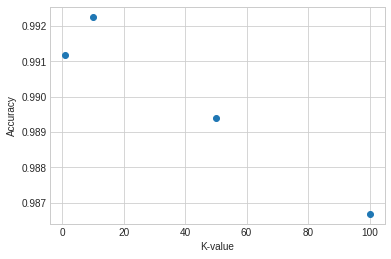

In [ ]:
k_list = [1,10,50,100]
acc = [0.9911904761904762,0.9922619047619048, 0.9894047619047619, 0.9866666666666667]
printScatterplot(k_list, acc, "K-value", "Accuracy")